#Sentiment Analysis of IMDB Movie reviews

In [ ]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

##Import Dependencies

In [2]:
import tensorflow as tf
import numpy as np
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer

##Download and explore dataset

In [3]:
# Check GPU availability
tf.config.list_physical_devices('GPU')

# Load the IMDb dataset
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Access the dataset split you're interested in (e.g., "train")
train_dataset = imdb["train"]

# Convert the TensorFlow dataset to a Pandas DataFrame
train_df = train_dataset.to_pandas()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Dataset statistics:
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000


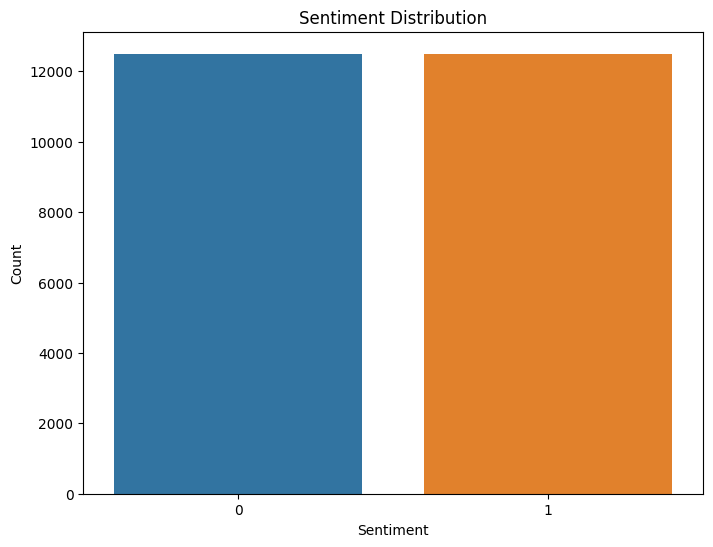

In [9]:
# Basic dataset statistics
print("\nDataset statistics:")
print(train_df.describe())

# Sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x="label")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

(-0.5, 799.5, 399.5, -0.5)

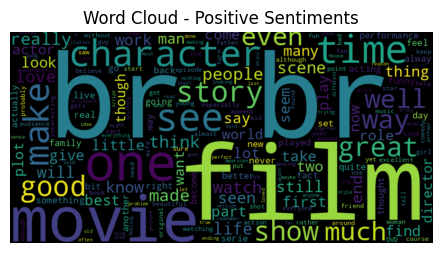

In [14]:
# Word cloud for positive and negative sentiments
from wordcloud import WordCloud

positive_reviews = train_df[train_df["label"] == 1 ]["text"]
negative_reviews = train_df[train_df["label"] == 0 ]["text"]



# Word cloud for positive reviews
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400).generate(" ".join(positive_reviews))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Word Cloud - Positive Sentiments")
plt.axis("off")


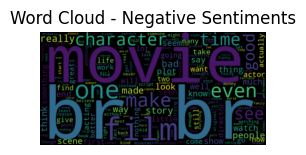

In [15]:
# Word cloud for negative reviews
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400).generate(" ".join(negative_reviews))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Word Cloud - Negative Sentiments")
plt.axis("off")
plt.show()

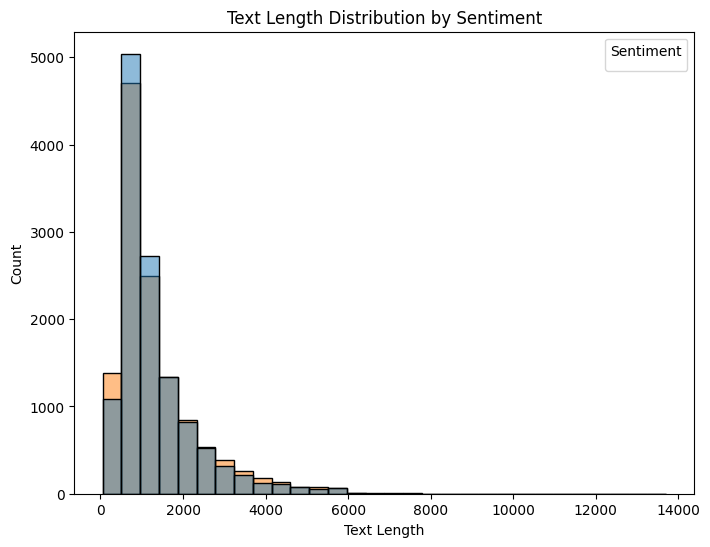

In [17]:
# Text length distribution
train_df["text_length"] = train_df["text"].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x="text_length", bins=30, hue="label", common_norm=False)
plt.title("Text Length Distribution by Sentiment")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.show()

In [5]:
train_df.head

<bound method NDFrame.head of                                                     text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]>

In [6]:
# Access the dataset split you're interested in (e.g., "train")
test_dataset = imdb["test"]

# Convert the TensorFlow dataset to a Pandas DataFrame
test_df = test_dataset.to_pandas()

In [ ]:
test_df

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [ ]:

small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(20000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(1000))])

##Initialise Tokenizer

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=512)


In [ ]:
# Tokenize the datasets
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)



Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

##Load Pre-trained model for fine-tuning

In [ ]:

# Load a pre-trained model
base_model = TFAutoModel.from_pretrained("distilbert-base-uncased")

input_layer = Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(512,), dtype=tf.int32, name="attention_mask")
embeddings = base_model(input_ids=input_layer, attention_mask=attention_mask)[0]
output_layer = Dense(1, activation="sigmoid")(embeddings)  # Sigmoid for binary classification

# Create a Keras model
model = Model(inputs=[input_layer, attention_mask], outputs=output_layer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


##Compile and Train Model

In [ ]:
model.compile(optimizer=Adam(3e-5), loss="binary_crossentropy", metrics=["accuracy"])



In [ ]:
train_data = {
    "input_ids": np.vstack(tokenized_train["input_ids"]),
    "attention_mask": np.vstack(tokenized_train["attention_mask"])
}
train_labels = np.array(small_train_dataset["label"])  # Labels are assumed to be integers (0 and 1)
train_labels = np.array(small_train_dataset["label"]).reshape(-1, 1)


In [ ]:
train_data

In [ ]:
# Prepare the validation data for evaluation
test_data = {
    "input_ids": np.vstack(tokenized_test["input_ids"]),
    "attention_mask": np.vstack(tokenized_test["attention_mask"])
}
test_labels = np.array(small_test_dataset["label"]).reshape(-1, 1)  # Ensure labels have the same shape as model output


In [ ]:
# Fit the model
model.fit(train_data, train_labels, epochs=3, batch_size=16, validation_data=(test_data, test_labels))



Epoch 1/3
1250/1250 [==============================] - 1190s 937ms/step - loss: 0.2706 - accuracy: 0.8864 - val_loss: 0.2178 - val_accuracy: 0.9076
Epoch 2/3
1250/1250 [==============================] - 1143s 914ms/step - loss: 0.1393 - accuracy: 0.9498 - val_loss: 0.2022 - val_accuracy: 0.9227
Epoch 3/3
1250/1250 [==============================] - 1135s 908ms/step - loss: 0.0656 - accuracy: 0.9775 - val_loss: 0.3023 - val_accuracy: 0.8955


##Evaluate Model

In [ ]:

# Fit the model

# Evaluate the model on the test data
eval_loss, eval_accuracy = model.evaluate(test_data, test_labels, batch_size=16)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

63/63 [==============================] - 18s 282ms/step - loss: 0.3023 - accuracy: 0.8955
Evaluation Loss: 0.3023
Evaluation Accuracy: 0.8955


In [ ]:
# Save the model to a file
model.save("sentiment_model")

# Optionally, save the tokenizer as well for future use
tokenizer.save_pretrained("sentiment_tokenizer")

('sentiment_tokenizer/tokenizer_config.json',
 'sentiment_tokenizer/special_tokens_map.json',
 'sentiment_tokenizer/vocab.txt',
 'sentiment_tokenizer/added_tokens.json',
 'sentiment_tokenizer/tokenizer.json')

In [ ]:
model.save("tf_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("sentiment_model.keras")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


##Test Model on random Data

In [ ]:
# Define a function to make predictions and return sentiment label

def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors="tf")

    # Make predictions
    logits = model.predict([inputs["input_ids"], inputs["attention_mask"]])

    # Apply sigmoid activation to get probability
    probability_positive = tf.sigmoid(logits)[0][0].numpy()

    # Determine sentiment label based on the probability
    if probability_positive > 0.5:
        sentiment_label = "Positive"
    else:
        sentiment_label = "Negative"

    return sentiment_label, probability_positive

# Example usage
text_to_predict = "Smugglers exudes a distinctive retro charm, masterfully blending with its high-octane action sequences. The film unapologetically showcases the treacherous world of backstabbing, double-crossing, and cutthroat negotiations. While this might sound complex, the movie's narrative is remarkably easy to follow. The 1970s setting is vividly captured, enhanced by the clever use of split screens during comedic moments."
sentiment_label, prob = predict_sentiment(text_to_predict)

# Print the sentiment label
print("probability: ", prob)
print(f"Sentiment: {sentiment_label}")

1/1 [==============================] - 0s 92ms/step
probability:  [0.7309887]
Sentiment: Positive


In [ ]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors="tf")

    # Make predictions
    logits = model.predict([inputs["input_ids"], inputs["attention_mask"]])

    # Apply sigmoid activation to get probabilities
    probability_positive = tf.sigmoid(logits)[0][0].numpy()
    probability_negative = 1 - probability_positive  # Complementary probability

    return {
        "positive_probability": probability_positive,
        "negative_probability": probability_negative
    }

# Example usage
text_to_predict = "One of the weakest entries in the J-horror remake sweepstakes, One Missed Call is undone by bland performances and shopworn shocks.One of the weakest entries in the J-horror remake sweepstakes, One Missed Call is undone by bland performances and shopworn shocks."
probabilities = predict_sentiment(text_to_predict)

# Print the probabilities
print("Positive Probability: ", probabilities["positive_probability"])
print("Negative Probability: ", probabilities["negative_probability"])

1/1 [==============================] - 0s 117ms/step
Positive Probability:  [0.5003318]
Negative Probability:  [0.49966818]
